In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
set_config(display='diagram')

warnings.filterwarnings('ignore')

color_pal = sns.color_palette()


In [298]:
df = pd.read_parquet('../Data/Drought_Monitor_DSCI_Datasets/weekly_tift_drought_status_dsci.parquet')
df.head(5)

,prcp_accum,air_temp_observed,air_temp_max,air_temp_min,air_temp_avg,smp_2,smp_4,smp_20,smp_40,soil_temp_2,...,date_offset,week,season,D0,D1,D2,D3,D4,DSCI,drought_status
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,4.650000,14.750000,22.750000,9.900000,15.750000,2.000000,5.700000,17.250000,25.050000,12.950000,...,1082,52,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-09,4.914286,10.542857,19.400000,6.414286,13.042857,1.942857,6.328571,16.800000,24.914286,10.928571,...,1089,1,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-16,5.600000,8.814286,20.257143,4.785714,12.428571,2.528571,7.614286,17.685714,25.114286,10.328571,...,1096,2,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-23,5.800000,9.433333,16.750000,5.800000,11.083333,1.283333,5.900000,17.233333,25.016667,10.583333,...,1103,3,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought
2000-01-30,7.285714,4.385714,9.442857,0.442857,4.671429,3.714286,8.300000,18.700000,25.700000,5.671429,...,1110,4,Winter,100.0,100.0,100.0,0.0,0.0,300.0,Severe Drought


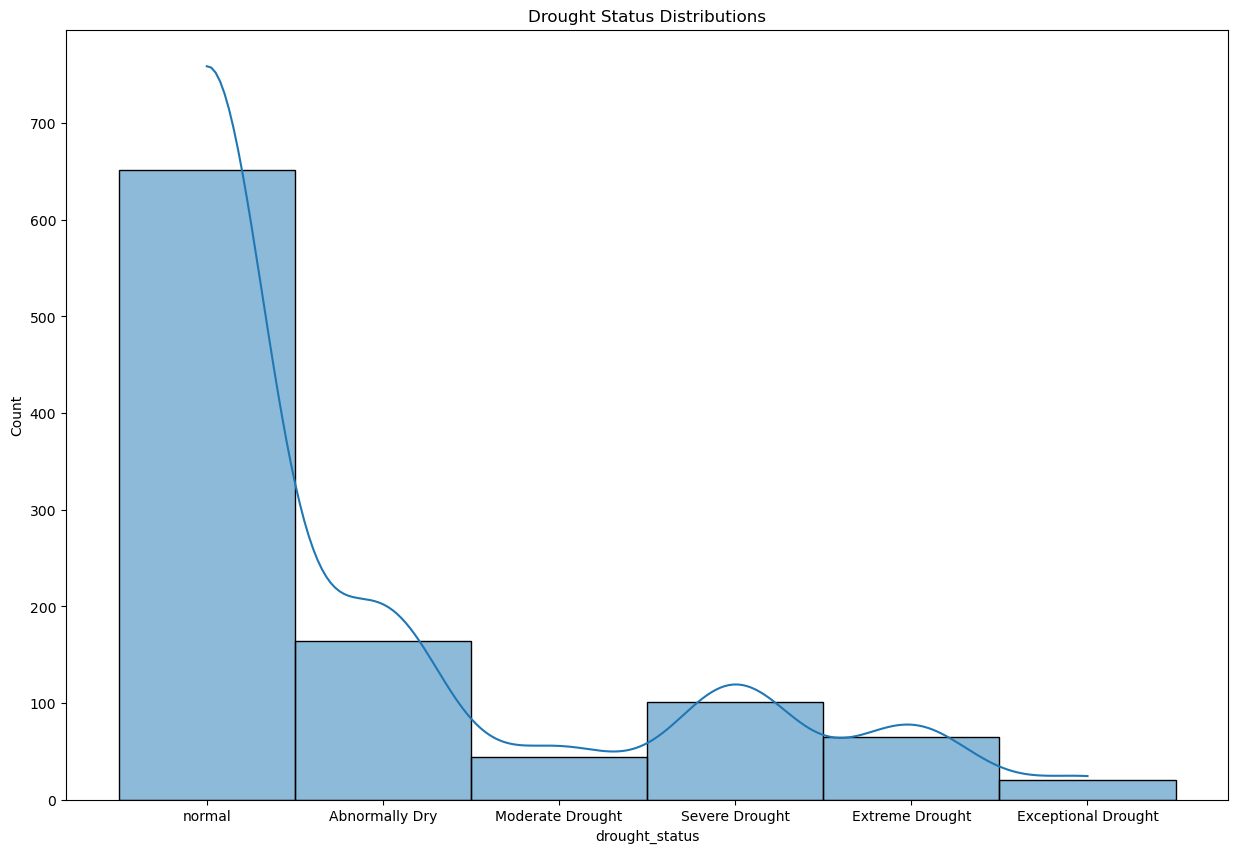

In [299]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(df, x='drought_status', kde=True)
ax.set_title('Drought Status Distributions')
plt.show()

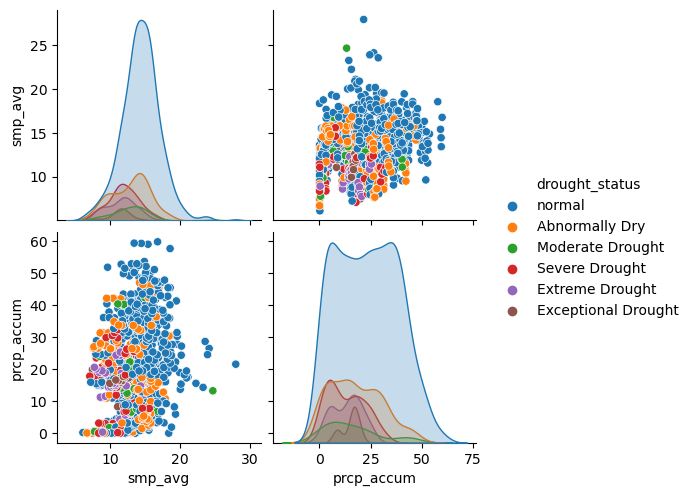

In [300]:

sns.pairplot(df[['drought_status','smp_avg','prcp_accum','season']], hue='drought_status')


In [301]:
le = LabelEncoder()
df['drought_status'] = le.fit_transform(df['drought_status'])

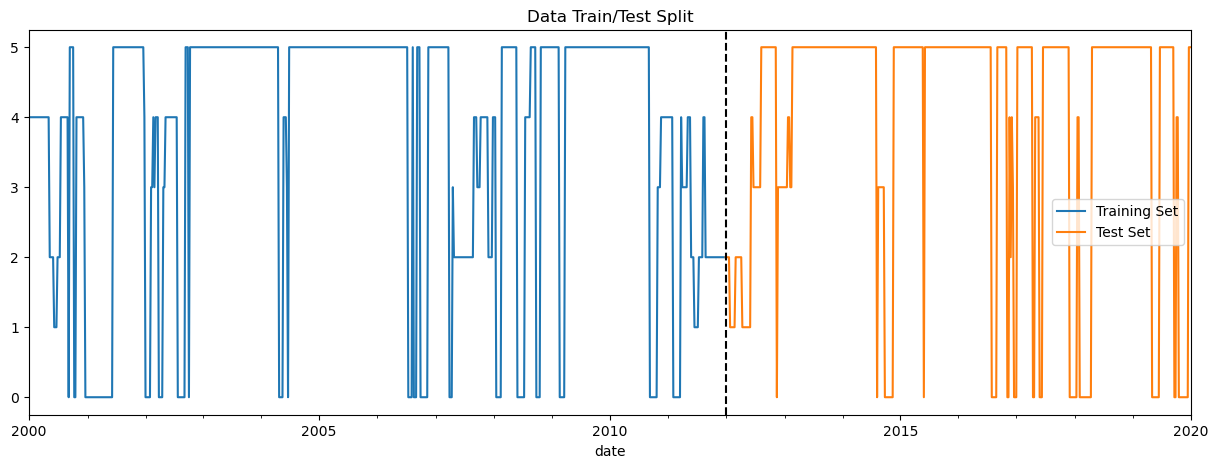

In [302]:
train = df.loc[df.index < '01-01-2012']
test = df.loc[df.index >= '01-01-2012']
fig, ax = plt.subplots(figsize=(15, 5))
train.drought_status.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.drought_status.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2012', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [303]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, gap=24)
df = df.sort_index()

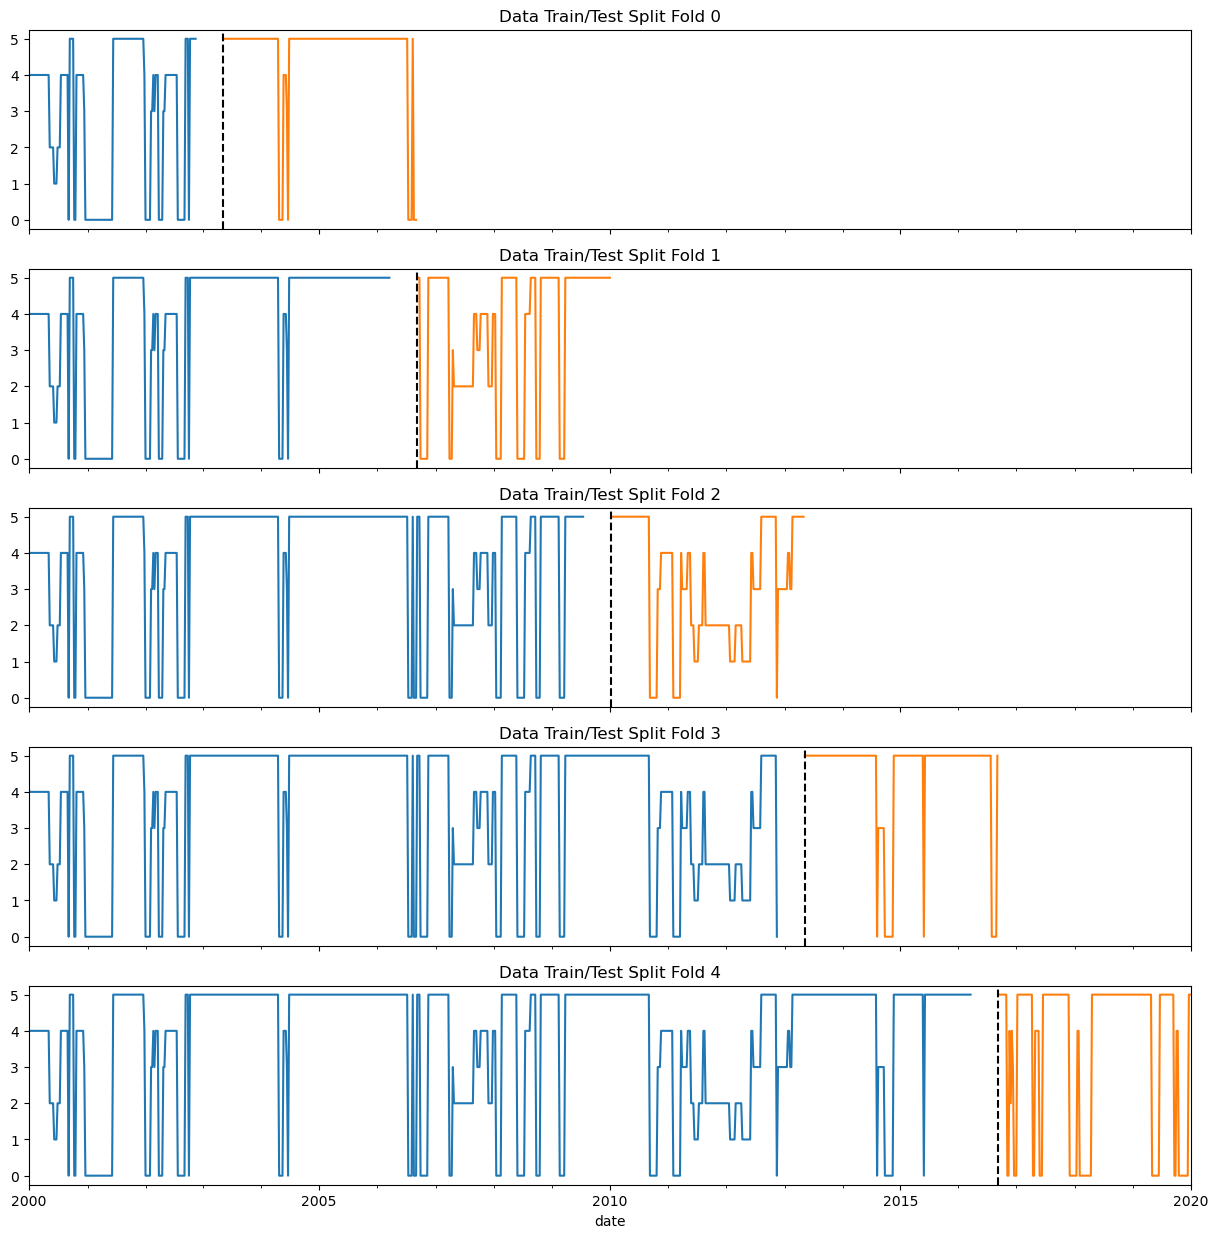

In [304]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['drought_status'].plot(ax=axs[fold],
                      label='Training Set',
                      title=f'Data Train/Test Split Fold {fold}')
    test['drought_status'].plot(ax=axs[fold],
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [305]:
def add_lags(df):
    target_map = df['drought_status'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [306]:
df = add_lags(df)

In [307]:
df['prcp'] = np.abs(df['prcp_accum'].diff())

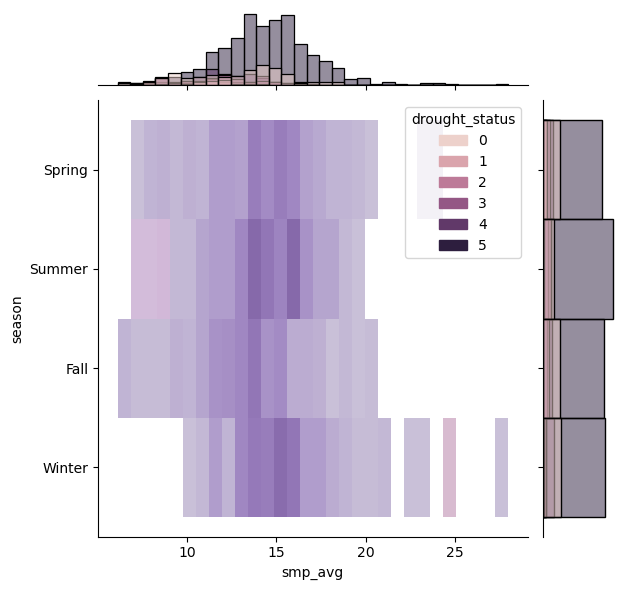

In [308]:
sns.jointplot(data=df, x=df['smp_avg'],y=df['season'], kind='hist', hue='drought_status')
plt.show()

In [309]:
df = df.drop(['weekday'],axis=1)

In [310]:

le = LabelEncoder()

df['season'] = le.fit_transform(df['season'])
train = df.loc[df.index < '01-01-2012']
test = df.loc[df.index >= '01-01-2012']
df = df.drop(['date'], axis=1)
df.head(5)

,prcp_accum,air_temp_observed,air_temp_max,air_temp_min,air_temp_avg,smp_2,smp_4,smp_20,smp_40,soil_temp_2,...,D1,D2,D3,D4,DSCI,drought_status,lag1,lag2,lag3,prcp
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,4.650000,14.750000,22.750000,9.900000,15.750000,2.000000,5.700000,17.250000,25.050000,12.950000,...,100.0,100.0,0.0,0.0,300.0,4,NaN,NaN,NaN,NaN
2000-01-09,4.914286,10.542857,19.400000,6.414286,13.042857,1.942857,6.328571,16.800000,24.914286,10.928571,...,100.0,100.0,0.0,0.0,300.0,4,NaN,NaN,NaN,0.264286
2000-01-16,5.600000,8.814286,20.257143,4.785714,12.428571,2.528571,7.614286,17.685714,25.114286,10.328571,...,100.0,100.0,0.0,0.0,300.0,4,NaN,NaN,NaN,0.685714
2000-01-23,5.800000,9.433333,16.750000,5.800000,11.083333,1.283333,5.900000,17.233333,25.016667,10.583333,...,100.0,100.0,0.0,0.0,300.0,4,NaN,NaN,NaN,0.200000
2000-01-30,7.285714,4.385714,9.442857,0.442857,4.671429,3.714286,8.300000,18.700000,25.700000,5.671429,...,100.0,100.0,0.0,0.0,300.0,4,NaN,NaN,NaN,1.485714


In [311]:
FEATURES = ['prcp_accum', 'air_temp_observed', 'air_temp_max', 'air_temp_min',
       'air_temp_avg', 'smp_2', 'smp_4', 'smp_20', 'smp_40', 'soil_temp_2',
       'soil_temp_4', 'soil_temp_8', 'soil_temp_20', 'soil_temp_40', 'wind_dir_avg',
       'wind_speed_avg', 'soil_temp_avg', 'smp_avg',
       'quarter', 'month', 'year',
       'weekofyear', 'date_offset', 'week', 'season', 'D0', 'D1', 'D2', 'D3',
       'D4', 'drought_status', 'lag1', 'lag2', 'lag3', 'prcp']
TARGET = 'DSCI'

In [312]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [313]:
len(FEATURES)

35

In [314]:
numeric_features = FEATURES[0:18] + FEATURES[25:39]
numeric_features

['prcp_accum',
 'air_temp_observed',
 'air_temp_max',
 'air_temp_min',
 'air_temp_avg',
 'smp_2',
 'smp_4',
 'smp_20',
 'smp_40',
 'soil_temp_2',
 'soil_temp_4',
 'soil_temp_8',
 'soil_temp_20',
 'soil_temp_40',
 'wind_dir_avg',
 'wind_speed_avg',
 'soil_temp_avg',
 'smp_avg',
 'D0',
 'D1',
 'D2',
 'D3',
 'D4',
 'drought_status',
 'lag1',
 'lag2',
 'lag3',
 'prcp']

In [315]:
numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder='passthrough',
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['prcp_accum', 'air_temp_observed',
                                  'air_temp_max', 'air_temp_min',
                                  'air_temp_avg', 'smp_2', 'smp_4', 'smp_20',
                                  'smp_40', 'soil_temp_2', 'soil_temp_4',
                                  'soil_temp_8', 'soil_temp_20', 'soil_temp_40',
                                  'wind_dir_avg', 'wind_speed_avg',
                                  'soil_temp_avg', 'smp_avg', 'D0', 'D1', 'D2',
                                  'D3', 'D4', 'drought_status', 'lag1', 'lag2',
                                  'lag3', 'prcp'])])

In [316]:
from sklearn.model_selection import cross_val_score


def objective(args):
    pipe = Pipeline(steps=[('preprocessing', preprocessor),
        ('model', args['model'])
    ])

    X_train_tf = pipe[:-1].fit_transform(X_train)
    X_test_tf = pipe[:-1].fit_transform(X_test)


    pipe[-1].set_params(**args['params'])
    pipe[-1].fit(X_train_tf, y_train, eval_metric='rmse',
            verbose=0)
    score = cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1)
    CrossValMean = score.mean()


    return {'loss': 1 - CrossValMean, 'status': STATUS_OK}

In [317]:
space = hp.choice('classifiers', [
    {
        'model': xgb.XGBRegressor(),
        'params': {'max_depth': hp.choice("max_depth", [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
                   'gamma': hp.uniform('gamma', 1, 9),
                   'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
                   'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                   'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
                   'n_estimators': hp.choice('n_estimators', [80,100,200,300,400,500]),
                   'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
                   'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]),
                   'seed': 0,

                   }
    }

])

In [318]:
from hyperopt import space_eval

trials = Trials()

best_classifier = fmin(objective, space, algo=tpe.suggest,
                       max_evals=50, trials=trials)


best_params = space_eval(space, best_classifier)

100%|██████████| 50/50 [00:31<00:00,  1.60trial/s, best loss: 0.0011549717199039744]


In [319]:
xgd_pipe = Pipeline(steps=[('preprocessing', preprocessor), ('reg',best_params['model'])])
xgd_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['prcp_accum',
                                                   'air_temp_observed',
                                                   'air_temp_max',
                                                   'air_temp_min',
                                                   'air_temp_avg', 'smp_2',
                                                   'smp_4', 'smp_20', 'smp_40',
                                                   'soil_temp_2', 'soil_temp_4',
                                                   'soil_temp_8',
                                                   'soil_te...
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=17,
                              min_child_weight=8.0, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=163.0,
                              reg_lambda=0.212382425358212, scale_pos_weight=1,
                              seed=0, subsample=0.74, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [320]:
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.metrics import ConfusionMatrixDisplay
train = df.loc[df.index < '01-01-2012']
test = df.loc[df.index >= '01-01-2012']
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_train_tf = xgd_pipe[:-1].fit_transform(X_train)
X_test_tf = xgd_pipe[:-1].fit_transform(X_test)

xgd_pipe[-1].fit(X_train_tf, y_train,
        verbose=0, eval_metric='rmse',eval_set=[(X_train_tf, y_train), (X_test_tf, y_test)])


y_pred = xgd_pipe.predict(X_test)

# TEST -- classification report and store predictions/ probabilities
print('Testing R^2 Report for estimator: ',
      str(xgd_pipe[-1]).split('(')[0])
score = r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

Testing R^2 Report for estimator:  XGBRegressor
The accuracy of our model is 96.0%


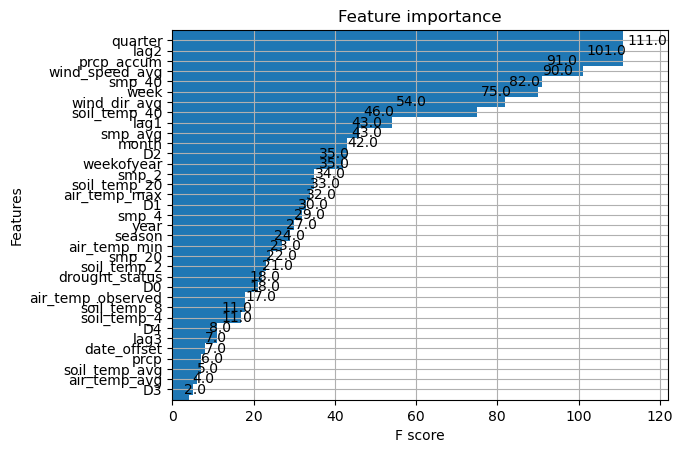

In [321]:
from xgboost import plot_importance

xgd_pipe[-1].get_booster().feature_names = FEATURES

_ = plot_importance(xgd_pipe[-1],height=5)

In [322]:
test['DSCI_PRED'] = xgd_pipe.predict(X_test)
DSCI_ALL = pd.concat([train,test], sort = False)

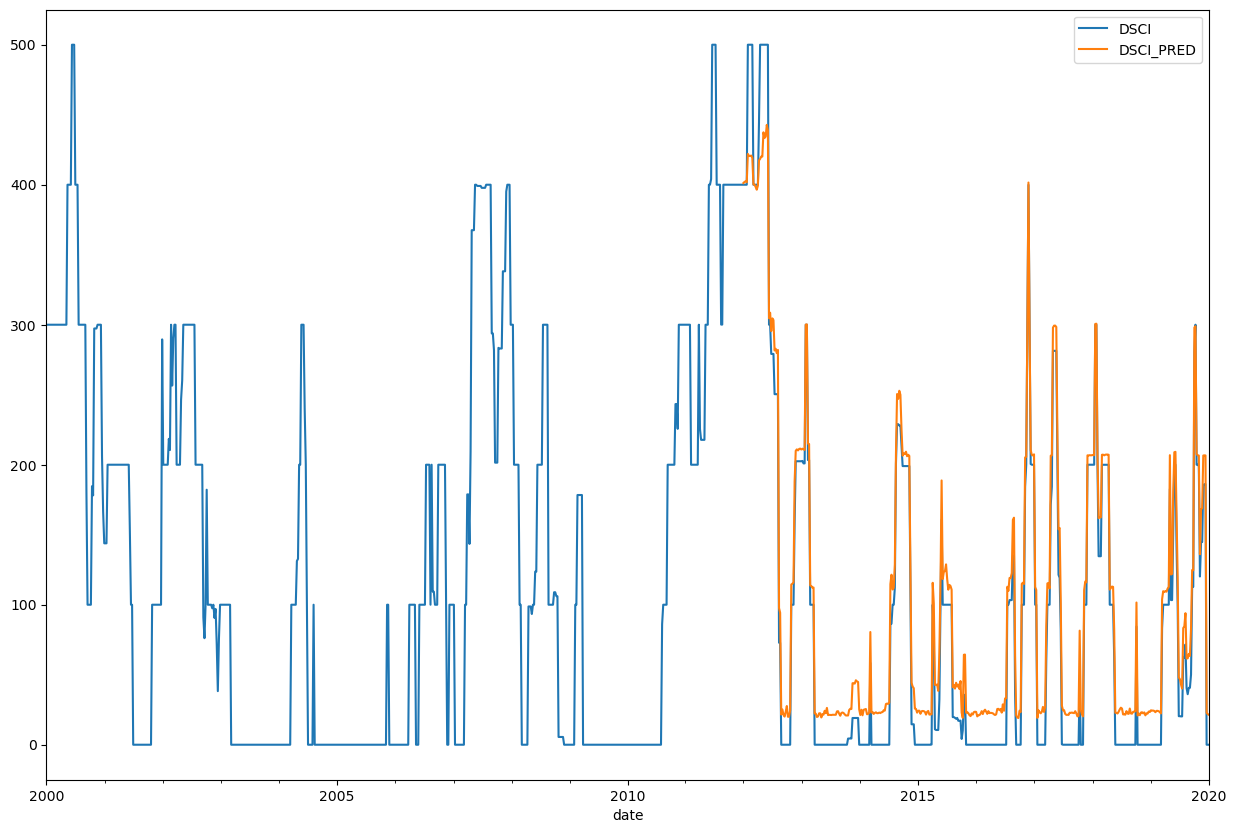

In [323]:
_ = DSCI_ALL[['DSCI','DSCI_PRED']].plot(figsize=(15,10))

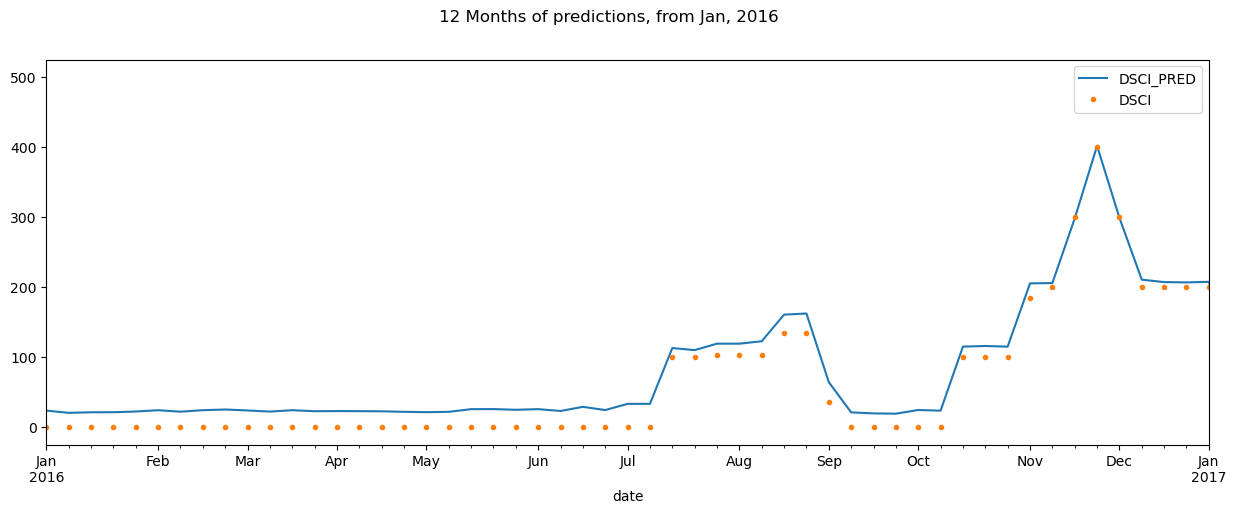

In [324]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = DSCI_ALL[['DSCI_PRED','DSCI']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2016', upper='01-01-2017')
plot = plt.suptitle('12 Months of predictions, from Jan, 2016')

In [325]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def collect_error_metrics(data, true_col, pred_col):

    RMSE = mean_squared_error(y_true=data[true_col],y_pred=data[pred_col])
    MAE = mean_absolute_error(y_true=data[true_col], y_pred=data[pred_col])
    MAPE = mean_absolute_percentage_error(y_true=data[true_col], y_pred=data[pred_col])


    return RMSE, MAE, MAPE


RMSE, MAE, MAPE = collect_error_metrics(test, 'DSCI','DSCI_PRED')

print('Our RMSE Error is', RMSE)
print('Our MAE Error is',MAE)
print('Our MAPE Error is', MAPE)

Our RMSE Error is 596.6578997789959
Our MAE Error is 21.30940076295402
Our MAPE Error is inf


In [326]:
SPI_test = test.copy()
SPI_test['error'] = SPI_test['DSCI'] - SPI_test['DSCI_PRED']
SPI_test['abs_error'] = SPI_test['error'].apply(np.abs)
error_by_month = SPI_test.groupby(['year', 'month']).mean()[['DSCI','DSCI_PRED','error','abs_error']]

In [327]:
# Worst Predicted year
error_by_month.sort_values('error', ascending=True).head(10)

,,DSCI,DSCI_PRED,error,abs_error
year,month,,,,
2017,6,80.7350,109.848343,-29.113342,29.113342
2012,7,261.8900,290.384155,-28.494155,28.494155
2015,5,62.8160,90.332512,-27.516513,27.516513
2014,6,0.0000,27.312868,-27.312868,27.312868
2015,4,49.2175,75.527031,-26.309533,26.309533
2014,7,68.2200,94.251389,-26.031387,26.031387
2013,12,15.2720,40.986961,-25.714961,25.714961
2016,6,0.0000,25.377026,-25.377025,25.377025
2014,12,3.6500,28.644670,-24.994671,24.994671
